# All Experiments cascade size vs runtime and frequency vs runtime

Galen Wilkerson

**The goal is to treat the Linear Threshold Model (LTM) as a statistical learning model.**

Initially -- simply when the cascade size (fraction of nodes $N$ labelled) exceeds a global threshold $\Phi_0$

Particularly, we are interested in how **cascade size or frequency grows as a function of:**

* number of edges added
* runtime complexity of computational rewiring algorithm (examining nodes or edges) 


# Global Parameters for all experiments

# & Setup and functions

In [1]:
import pandas as pd
from GlobalCascadeNetwork import *

%matplotlib inline
# %load_ext memory_profiler

from scipy.interpolate import splev, splrep

import cProfile

from scipy.spatial import cKDTree

sns.set_palette("bright")

import time


from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets


params = {'legend.fontsize': 24,
          'figure.figsize': (15, 5),
         'axes.labelsize': 24,
         'axes.titlesize': 24,
         'xtick.labelsize': 24,
         'ytick.labelsize': 24}

plt.rcParams["axes.grid"] = False
plt.rcParams['figure.dpi'] = 1200
# plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams.update(params)

from numpy import inf


########################################################

# global parameters for all experiments


layer_size = 10
num_layers = 10

layer_sizes = [layer_size] * num_layers # in case layered
N = np.sum(layer_sizes) # in case not layered

p = 0 # empty graph initially

num_trials = 200

# maximum number of edges depends on topology constraints (ER, layered etc)
# for now, just use Erdos-Renyi Maximum number of edges
#max_num_edges = int(((N * (N - 1))/2) /2) # complete graph /2

max_z = 8  # based on watts paper
max_num_edges = int(N * max_z/2)

num_edges_step_size = 50

num_seeds = 1

verbose = 2

phi = 0.18 # a default value

# radii of influence for spatial case
# num_radii = 7
# max_radius = 1.42
# min_radius = .1

# set radii to cover a range of values
radii = [0.1 , 0.2, 0.3, 0.4, 0.56, 1.00, 1.42]

# half of the max radius
#mid_radius = radii[-1]/2

# a table of experment choices
df_experiments = pd.read_csv('latest_experiment_choices3.csv', index_col=0)

########################################################

def log_distribute_radii(num_radii = 5,
                         maxval = 1.42,
                         minval = 0.1):
    logmax = np.log(maxval)
    logmin = np.log(minval)

    vals = np.arange(logmin, logmax, (logmax - logmin)/(num_radii-1))

    exp_vals = np.exp(vals)
    exp_vals = np.append(exp_vals, maxval)
    return(exp_vals)

def cascade_sizes_over_edges_trials(N,
                                    p, 
                                    phis,
                                    num_seeds,
                                    max_num_edges, 
                                    num_trials,
                                    verbose = False):
    '''
    starting from empty graph for LTM, run many trials and calculate cascade sizes
    '''
    
    cascade_sizes = np.zeros([max_num_edges, num_trials])

    for i in range(num_trials):

        #if verbose:
            #if i % 5 == 0:
            #    print('trial', i)

        cascadeNet = GlobalCascadeNetwork(N = N,
                                          p = p, 
                                          phis = phi,
                                          num_seeds = num_seeds)

        for num_edges in range(max_num_edges):

                cascadeNet.reset_all_labels_except_seeds()
                cascadeNet.synchronous_cascade()
                cascade_sizes[num_edges, i] = cascadeNet.cascade_fraction()
                cascadeNet.add_random_edge()
                
    return(cascade_sizes, cascadeNet)

def cascade_sizes_over_edges(N,
                             p, 
                             phis,
                             num_seeds,
                             max_num_edges, 
                             i,
                             verbose = False):
    '''
    starting from empty graph for LTM, run many trials and calculate cascade sizes
    '''
    
    cascade_sizes = np.zeros([max_num_edges])

    if verbose:
        #if i % 5 == 0:
        print('trial', i)

    cascadeNet = GlobalCascadeNetwork(N = N,
                                      p = p, 
                                      phis = phis,
                                      num_seeds = num_seeds)

    for num_edges in range(max_num_edges):

        cascadeNet.reset_all_labels_except_seeds()
        cascadeNet.synchronous_cascade()
        cascade_sizes[num_edges] = cascadeNet.cascade_fraction()
        #cascadeNet.add_random_edge()
        cascadeNet.add_random_edge_fast()
                
    return(cascade_sizes)



def parallelize_cascade_size_trials(num_trials=100,
                                    N=1000,
                                    p=.5,
                                    num_seeds=1,
                                    phi_values=.5,
                                    max_z = 8,
                                    verbose = False): # based on watts paper
    '''
    function to use joblib for parallelism

    I DON'T TRUST THIS, GIVES DIFFERENT RESULTS FROM SERIAL METHOD!!
    '''
      
    max_num_edges = int(N * max_z/2)

    result = Parallel(n_jobs=-1)(delayed(cascade_sizes_over_edges)(N=N,
                                                                   p=p,
                                                                   phis=phi_values,
                                                                   num_seeds=num_seeds,
                                                                   max_num_edges = max_num_edges,
                                                                   i = i,
                                                                   verbose = verbose)
                                 for i in range(num_trials))

    return (result)

def cascade_sizes_over_edges_ER_spatial(N,
                                        p, 
                                        phi,
                                        num_seeds,
                                        max_num_edges, 
                                        radius,
                                        which_dim,
                                        i,
                                        num_edges_step_size = 1,
                                        verbose = False):
    '''
    starting from empty graph for LTM, run many trials and calculate cascade sizes
    '''
    
#     cascade_sizes = np.zeros([int(max_num_edges/num_edges_step_size) + 1])
    cascade_sizes = []
    available_edges = []
    
    if verbose:
        #if i % 5 == 0:
        print('trial', i)


    cascadeNet = GlobalCascadeNetwork(N = N,
                                      p = p, 
                                      phis = phi,
                                      num_seeds = num_seeds)#,  
                                      #network_generator = 'layered', 
                                      #layer_sizes = layer_sizes)

    for num_edges in range(0, max_num_edges, num_edges_step_size):

        cascadeNet.reset_all_labels_except_seeds()
        cascadeNet.synchronous_cascade()
#         cascade_sizes[num_edges] = cascadeNet.cascade_fraction()
        cascade_sizes.append(cascadeNet.cascade_fraction())
        #cascadeNet.add_random_edge()
        #cascadeNet.add_random_edge_layered()
        
        # add multiple edges
        for j in range(num_edges_step_size):
            result = cascadeNet.add_random_edge_ER_within_radius_fast(radius,
                                                                      which_dim)
#         if result is None:
#             break
        available_edges.append(result[1])
    
    return(cascade_sizes, available_edges)

def parallelize_cascade_size_trials_ER_spatial(num_trials=100,
                                               N=1000,
                                               p=.5,
                                               num_seeds=1,
                                               phi_values=.5,
                                               radius = 1,
                                               which_dim = 'both',
                                               max_z = 8,
                                               num_edges_step_size = 1,
                                               verbose = False): # based on watts paper
    '''
    function to use joblib for parallelism

    I DON'T TRUST THIS, GIVES DIFFERENT RESULTS FROM SERIAL METHOD!!
    '''
      
    max_num_edges = int(N * max_z/2)

    result = Parallel(n_jobs=-1)(delayed(cascade_sizes_over_edges_ER_spatial)(N=N,
                                                                              p=p,
                                                                              phi=phi_values,
                                                                              num_seeds=num_seeds,
                                                                              max_num_edges = max_num_edges,
                                                                              radius = radius,
                                                                              which_dim = which_dim,
                                                                              i = i,
                                                                              num_edges_step_size = num_edges_step_size,
                                                                              verbose = verbose)
                                 for i in range(num_trials))

    return(np.array(result))




def cascade_sizes_over_edges_layered(layer_sizes, #N,
                                     p, 
                                     phi,
                                     num_seeds,
                                     max_num_edges, 
                                     radius,
                                     which_dim,
                                     i,
                                     verbose = False):
    '''
    starting from empty graph for LTM, run many trials and calculate cascade sizes
    '''
    
    cascade_sizes = np.zeros([max_num_edges])

    if verbose:
        #if i % 5 == 0:
        print('trial', i)

#     cascadeNet = GlobalCascadeNetwork(N = N,
#                                       p = p, 
#                                       phis = phis,
#                                       num_seeds = num_seeds)
    
    cascadeNet = GlobalCascadeNetwork(p = p, 
                                      phis = phi,
                                      num_seeds = num_seeds,  
                                      network_generator = 'layered', 
                                      layer_sizes = layer_sizes)

    for num_edges in range(max_num_edges):

        cascadeNet.reset_all_labels_except_seeds()
        cascadeNet.synchronous_cascade()
        cascade_sizes[num_edges] = cascadeNet.cascade_fraction()
        #cascadeNet.add_random_edge()
        #cascadeNet.add_random_edge_layered()
        result = cascadeNet.add_random_edge_layered_within_radius_fast(radius,
                                                                      which_dim)
#         if result is None:
#             break
        
    return(cascade_sizes)

def cascade_size_trials_layered(num_trials=100,
#                                             N=1000,
                                            layer_sizes = [5,5,5],
                                            p=.5,
                                            num_seeds=1,
                                            phi_values=.5,
                                            radius = 1,
                                            which_dim = 0,
                                            max_z = 8,
                                            verbose = False): # based on watts paper

    max_num_edges = int(N * max_z/2)
    #cascade_sizes = np.zeros([max_num_edges, num_trials])
    results = []
    
    for i in range(num_trials):
    
        result = cascade_sizes_over_edges_layered(layer_sizes = layer_sizes, #N=N,
                                                  p=p,
                                                  phi=phi_values,
                                                  num_seeds=num_seeds,
                                                  max_num_edges = max_num_edges,
                                                  radius = radius,
                                                  which_dim = which_dim,
                                                  i = i,
                                                  verbose = verbose)
        results.append(result)
        
    return(results)
    

def parallelize_cascade_size_trials_layered(num_trials=100,
#                                             N=1000,
                                            layer_sizes = [5,5,5],
                                            p=.5,
                                            num_seeds=1,
                                            phi_values=.5,
                                            radius = 1,
                                            which_dim = 0,
                                            max_z = 8,
                                            verbose = False): # based on watts paper
    '''
    function to use joblib for parallelism

    I DON'T TRUST THIS, GIVES DIFFERENT RESULTS FROM SERIAL METHOD!!
    '''
      
    max_num_edges = int(N * max_z/2)

    result = Parallel(n_jobs=-1)(delayed(cascade_sizes_over_edges_layered)(layer_sizes = layer_sizes, #N=N,
                                                                           p=p,
                                                                           phi=phi_values,
                                                                           num_seeds=num_seeds,
                                                                           max_num_edges = max_num_edges,
                                                                           radius = radius,
                                                                           which_dim = which_dim,
                                                                           i = i,
                                                                           verbose = verbose)
                                 for i in range(num_trials))

    return (np.array(result))





def cascade_sizes_over_runtime_trials(N, p, phi, num_seeds, num_trials,  pad_steps = 5, verbose = False):
    '''
    starting from empty graph for LTM:
    
    over many trials:
        while there are unlabelled nodes:
            add one edge between random unlabelled and random labelled node
            reset non-seed nodes
            cascade sizes <- run cascade
    '''
    
    all_cumulative_runtimes = []
    all_cascade_sizes = []
    
    for i in range(num_trials):

        if verbose:
            if i % 5 == 0:
                print(i)

        total_runtime = [0]
        cascade_sizes = [0]

        cascadeNet = GlobalCascadeNetwork(N = N,
                                          p = p, 
                                          phis = phi,
                                          num_seeds = num_seeds)

        while len(cascadeNet.get_unlabeled_ids()) > 0:
            # find an unlabelled and a labelled node
            unlabelled_node, unlabelled_search_time = find_labelled_unlabelled_node(cascadeNet, labelled=False)
            labelled_node, labelled_search_time = find_labelled_unlabelled_node(cascadeNet, labelled=True)
            total_runtime.append(unlabelled_search_time + labelled_search_time)

            new_edge = (unlabelled_node, labelled_node)
            if not cascadeNet.has_edge(new_edge):
                cascadeNet.add_edge(new_edge)
            else:
                print('edge already exists') # this should be impossible in this scenario

            cascadeNet.reset_all_labels_except_seeds()
            cascadeNet.synchronous_cascade()
            cascade_sizes.append(cascadeNet.cascade_fraction())

        cumulative_runtimes = np.cumsum(total_runtime)

        all_cumulative_runtimes.append(cumulative_runtimes)
        all_cascade_sizes.append(cascade_sizes)
        
    # in prep for interpolation
    # pad out each runtime to the max of all runtimes
    # and duplicate the last cascade size
    max_runtime = max([max(x) for x in all_cumulative_runtimes])
    
    # pad them out in pad_steps to the max value
    if pad_steps > 0:
        for i in range(len(all_cumulative_runtimes)):
            last_runtime_index = len(all_cumulative_runtimes[i]) - 1
            last_runtime_value = all_cumulative_runtimes[i][last_runtime_index]
            
            if last_runtime_value < max_runtime:
                runtime_pad_values = np.arange(last_runtime_value, max_runtime, 
                                               (max_runtime - last_runtime_value) / pad_steps)
                all_cumulative_runtimes[i] = np.append(all_cumulative_runtimes[i], runtime_pad_values)
                # extend the cascade sizes list for each trial by the number of new runtime pad values above
                all_cascade_sizes[i].extend([all_cascade_sizes[i][-1]] * len(runtime_pad_values))
        
    return(all_cascade_sizes, all_cumulative_runtimes)


def spline_interpolate_cascade_sizes(all_cascade_sizes, smoothing_factor = 0.1, verbose = False):
    
    # set xnew according to longest cascade sizes list
    max_length = max([len(x) for x in all_cascade_sizes])
    xnew = np.arange(max_length)

    new_xs = []
    new_ys = []
    
    for i in range(len(all_cascade_sizes)):
        
        x = np.arange(len(all_cascade_sizes[i]))
        y = all_cascade_sizes[i]
        spl = splrep(x, y, s = smoothing_factor)
        
        y2 = splev(xnew, spl)
        
        new_xs.append(xnew)
        new_ys.append(y2)
        
    num_edges = np.array(new_xs)
    cascade_sizes_interpd = np.array(new_ys)
    
    return(num_edges, cascade_sizes_interpd)


def spline_interpolate(all_cumulative_runtimes, 
                       all_cascade_sizes, 
                       num_steps, 
                       smoothing_factor = 0.1,
                       verbose = False):
    '''
    interpolate runtimes vs cascade sizes
    
    return 
    '''
    
    new_xs = []
    new_ys = []

    min_runtime = min([min(x) for x in all_cumulative_runtimes])
    max_runtime = max([max(x) for x in all_cumulative_runtimes])
    
    if verbose:
        print('num interpolation steps', num_steps)
        
    for i in range(len(all_cumulative_runtimes)):

        x = all_cumulative_runtimes[i]
        y = all_cascade_sizes[i]
        spl = splrep(x, y, s = smoothing_factor)
        
        # could do this outside of loop
        xnew = np.arange(min_runtime, max_runtime, (max_runtime - min_runtime)/num_steps)
        #xnew = np.arange(x[0], x[-1], (x[-1] - x[0])/num_steps)
        y2 = splev(xnew, spl)

        new_xs.append(xnew[:num_steps])
        new_ys.append(y2[:num_steps])


    # take mean vector of runtimes and cascade sizes
    runtimes_interpd = np.array(new_xs)
    cascade_sizes_interpd = np.array(new_ys)

    return(runtimes_interpd, cascade_sizes_interpd)



# random order to search through all nodes
def find_labelled_unlabelled_node(cascadeNet, labelled = True):
    
    # find 1st random labelled or unlabelled node
    # labelled = True: search for labelled node
    # labelled = False: search for unlabelled node
    # return random labelled/unlabelled node and search time
    N = cascadeNet.G.numberOfNodes()
    search_order = list(np.random.choice(N, N, replace=False))
    found = False
    
    for i in range(len(search_order)):
        node = search_order[i]
        if cascadeNet.labels[node] == labelled:
            found = True
            break
    
    if found:
        return(node, i+1)
    else:
        return(None, None)

# functions for frequency

def calculate_global_cascade_counts(cascade_sizes, cascade_threshold):
    '''
    global cascade counts function 
    
    calculates actual counts, not frequency
    
    cascade_sizes has dimensions: [number of edges, num_trials]
    
    cascade_threshold is global cascade size threshold (Phi_0 from the Watts paper)

    returns (array of number of edges, array of number above cascade_threshold)
    
    Note, this should also work for mean degree or p values for Erdos-Renyi networks,
          where the input cascade_sizes has dimensions: [number of p (or z) values, num_trials]
    '''
    
    x = np.arange(0,cascade_sizes.shape[0])

    num_above_threshold = []

    for i in x:
        num_above_threshold.append(len(np.where(cascade_sizes[i]>=cascade_threshold)[0]))
    
    return(x, num_above_threshold)

def calculate_global_cascade_frequency(cascade_sizes, cascade_threshold):
    '''
    get the counts above the threshold, then normalize to obtain frequency
    '''
    
    num_trials = cascade_sizes.shape[1]
    x, counts = calculate_global_cascade_counts(cascade_sizes, cascade_threshold)
    
    frequency = np.array(counts)/num_trials
    
    return(x, frequency)


# helper functions to convert between binary vectors and list of seed ids

def seed_list_to_seed_vect(seeds):
    last_node = np.max(seeds)

    seed_vect = []
    for i in range(last_node + 1):
        if i in seeds:
            seed_vect.append(1)
        else:
            seed_vect.append(0)
    return(seed_vect)

def seed_vect_to_seed_list(seed_vect):
    seeds = []
    for i in range(len(seed_vect)):
        if seed_vect[i] == 1:
            seeds.append(i)
    return(seeds)


def run_experiment(phi, 
                   which_dim,
                   topology,
                   #Phi_0,
                   radius,
                   layer_sizes,
                   N, 
                   p, 
                   num_trials, 
                   max_num_edges,
                   max_z, 
                   num_seeds, 
                   verbose, 
                   num_edges_step_size = 1):
    
    if verbose:
        print('running experiment:\n',
          'phi', phi, 
          '\nwhich_dim', which_dim, 
          '\ntopology', topology, 
          #'\nPhi_0', Phi_0, 
          '\nradius', radius,
          '\nlayer_sizes', layer_sizes ,
          '\nN', N, 
          '\np', p, 
          '\nnum trials', num_trials, 
          '\nmax_num_edges', max_num_edges, 
          '\nnum_seeds', num_seeds, 
          '\nverbose', verbose,
          '\nnum_edges_step_size', num_edges_step_size)
    print()
    
    # pass verbose on if level 2
    verbose = (verbose == 2)
    
    
    all_params = locals()
    
    if topology == 'Erdos-Renyi':
        results = parallelize_cascade_size_trials_ER_spatial(num_trials=num_trials,
                                                             N=N,
                                                             p=p,
                                                             num_seeds=num_seeds,
                                                             phi_values=phi,
                                                             radius = radius,
                                                             which_dim = which_dim,
                                                             max_z = max_z,
                                                             num_edges_step_size = num_edges_step_size,
                                                             verbose = verbose)
        
    elif topology == 'Layered':
        results = parallelize_cascade_size_trials_layered(num_trials=num_trials,
                                                            layer_sizes = layer_sizes,
                                                            p=p,
                                                            num_seeds=num_seeds,
                                                            phi_values=phi,
                                                            radius = radius,
                                                            which_dim = which_dim,
                                                            max_z = max_z,
                                                            verbose = verbose)
        
    return(all_params, results)

def run_all_experiments(parameter_names,
                        all_experiment_parameters,
                        layer_sizes,
                        N, 
                        p, 
                        num_trials, 
                        max_num_edges,
                        max_z, 
                        num_seeds, 
                        verbose):
    
    num_experiments = len(all_experiment_parameters)
    
    all_params = []
    all_results = []
    start_time = time.time()
#     local_start_time = time.ctime(start_time)
    for i in range(num_experiments):
        
        experiment_parameters = all_experiment_parameters[i]

        keys = parameter_names
        values = experiment_parameters
        param_dict = dict(zip(keys, values))

        if (param_dict['phi']) == 'Random Uniform':
            phi = None
        else:
            phi = float(param_dict['phi'])
            
        dimensionality = param_dict['dimensionality']
        if dimensionality == 1:
            which_dim = 0
        else:
            which_dim = 'both'

        topology = param_dict['topology']
        #Phi_0 = param_dict['Phi_0']
        radius = float(param_dict['radius'])


        params, results = run_experiment(phi, 
                                   which_dim,
                                   topology,
                                   #Phi_0,
                                   radius,
                                   layer_sizes,
                                   N, 
                                   p, 
                                   num_trials, 
                                   max_num_edges,
                                   max_z, 
                                   num_seeds, 
                                   verbose)
        all_params.append(params)
        all_results.append(results)
        end__experiment_time = time.time()
        
        total_time_so_far = end__experiment_time - start_time
        time_per_experiment = total_time_so_far/(i+1)
        estimated_total_time = time_per_experiment * num_experiments
        estimated_local_end_time = time.ctime(start_time + estimated_total_time)
        print('time per experiment(mins):', str(round(time_per_experiment/60, 3)), 
              'estimated end time', str(estimated_local_end_time))
        print()
    return(all_params, np.array(all_results))



def plot_experiment(results, 
                    radius,
                    #params, 
                    #experiments_df, 
                    #exp_id, 
                    ci = 95, 
                    title = 'cascade sizes'):
    # plot one experiment
    experiment_result = results#[exp_id, :, :]
    df = pd.DataFrame(experiment_result).T
    df['num edges'] = df.index
    df2 = df.melt('num edges',var_name='cols',  value_name='vals')
    df2.columns = ['num edges', 'trial', 'cascade size']

#     d = experiments_df[str(exp_id)]
#     label = d.to_string()
#     label = '_'.join(label.split())
    label = 'r = ' + str(radius)
    
#     title = 'cascade sizes vs. num edges N = ' + str(params[exp_id]['N']) + \
#     ' num trials = ' + str(params[exp_id]['num_trials'])
    
    title = ''
    
    sns.lineplot(x="num edges", y="cascade size", ci=95, markers='.', label = label,
                         #hue="cols",#, style="event",
                         data=df2);
    plt.title(title);
    
def plot_pareto_frontier(Xs, Ys, maxX=True, maxY=True):
    '''Pareto frontier selection process'''
    sorted_list = sorted([[Xs[i], Ys[i]] for i in range(len(Xs))], reverse=maxY)
    pareto_front = [sorted_list[0]]
    for pair in sorted_list[1:]:
        if maxY:
            if pair[1] >= pareto_front[-1][1]:
                pareto_front.append(pair)
        else:
            if pair[1] <= pareto_front[-1][1]:
                pareto_front.append(pair)
    
    '''Plotting process'''
    categories = np.array([0, 1,2,3,4,5])

    colormap = np.array(['blue', 'orange', 'green', 'red', 'purple', 'brown'])

    fig = plt.figure(figsize=[10,10]);

    plt.rcParams["axes.grid"] = False

    pf_X = [pair[0] for pair in pareto_front]
    pf_Y = [pair[1] for pair in pareto_front]
    plt.plot(pf_X, pf_Y, 'black', linewidth = 4, alpha = .7)

    plt.xlabel('maximum cascade frequency')

    plt.ylabel('maximum cascade efficiency')


    for i in range(0, len(radii)-1):
        plt.scatter(Xs[i], Ys[i], label = 'r = ' +str(radii[i+1]), linewidth = 10, alpha=1);
        
    plt.legend()
  
    plt.show()
    return(fig)


# Show experiment parameters

In [2]:
df_experiments

,0,1,2,3,4,5,6,7,8,9,...,38,39,40,41,42,43,44,45,46,47
phi,0.18,0.18,0.18,0.18,0.18,0.18,0.18,0.18,0.18,0.18,...,Random Uniform,Random Uniform,Random Uniform,Random Uniform,Random Uniform,Random Uniform,Random Uniform,Random Uniform,Random Uniform,Random Uniform
dimensionality,1,1,1,1,1,1,1,1,2,2,...,1,1,2,2,2,2,2,2,2,2
topology,Erdos-Renyi,Erdos-Renyi,Erdos-Renyi,Erdos-Renyi,Layered,Layered,Layered,Layered,Erdos-Renyi,Erdos-Renyi,...,Layered,Layered,Erdos-Renyi,Erdos-Renyi,Erdos-Renyi,Erdos-Renyi,Layered,Layered,Layered,Layered
radius,0.1,0.54,0.98,1.42,0.1,0.54,0.98,1.42,0.1,0.54,...,0.98,1.42,0.1,0.54,0.98,1.42,0.1,0.54,0.98,1.42


# test radii for Erdos-Renyi 2 dimensional

In [3]:
radii

[0.1, 0.2, 0.3, 0.4, 0.56, 1.0, 1.42]

In [4]:
num_trials

200

In [5]:
max_num_edges

400

# Run experiments
## (change cell below to 'code' to re-run experiments)

all_params = []
all_results = []

for radius in radii:
    
    topology = 'Erdos-Renyi'
    which_dim = 'both'

    params, results = run_experiment(phi, 
                                     which_dim,
                                     topology,
                                     #Phi_0,
                                     radius,
                                     layer_sizes,
                                     N, 
                                     p, 
                                     num_trials, 
                                     max_num_edges,
                                     max_z, 
                                     num_seeds, 
                                     verbose,
                                     num_edges_step_size=num_edges_step_size)
    all_params.append(params)
    all_results.append(results)

# Save experiment results to file

pd.to_pickle((all_params, all_results), "effects_radius_params_results_100_200_50_#3.pkl")

# Load experiment results from file

In [6]:
(all_params, all_results) = pd.read_pickle("effects_radius_params_results_100_200_50_#3.pkl")

## Extract results array from tuple
## [num_radii x num_trials x 2 x (max_num_edges / num_edges_step_size)] 

In [7]:
all_results_array = np.array(all_results)
all_results_array.shape

(7, 200, 2, 8)

## Extract cascade sizes

In [30]:
cascade_sizes = all_results_array[:, :, 0, :]

## Extract available edges

available_edges = all_results_array[:, :, 1, :]


## Examine cascade sizes

In [32]:
# [num_radii x max_num_edges]
df_cascade_sizes = pd.DataFrame(cascade_sizes[:,0,:])


df_available_edges = pd.DataFrame(available_edges[:,0,:])


# calculate cascade size / available edges

In [33]:
df_cascade_by_available_edges = df_cascade_sizes.div(df_available_edges).T

df_cascade_by_available_edges.columns = np.round(radii, 2)

# approximate available nodes by 

$$
E = \frac{N(N-1)}{2} \sim \frac{N^2}{2}
$$

$$
N \sim \sqrt{2 E}
$$

In [34]:
df_available_nodes = ((df_available_edges * 2) ** .5)

df_cascade_by_available_nodes = df_cascade_sizes.div(df_available_nodes).T
df_cascade_by_available_nodes.columns = np.round(radii, 2)

# find average cascade size / average available edges

In [35]:
# [num_radii x num_trials x max_num_edges]
cascade_size_by_available_edges = cascade_sizes/available_edges

/home/galen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [38]:
mean_cascade_size_by_available_edges = cascade_size_by_available_edges.mean(axis=1)
df_mean_cascade_size_by_available_edges = pd.DataFrame(mean_cascade_size_by_available_edges).T
df_mean_cascade_size_by_available_edges.columns = np.round(radii,2)


## Convert none entries to zero

In [39]:
available_edges[available_edges == None] = 0

# plot cascade size / available edges with confidence intervals

In [40]:
# [num_radii x num_trials x 2 x (max_num_edges / num_edges_step_size)] 

all_results_array = np.array(all_results)


In [41]:
cascade_sizes = all_results_array[:, :, 0, :]
available_edges = all_results_array[:, :, 1, :]



# available edges

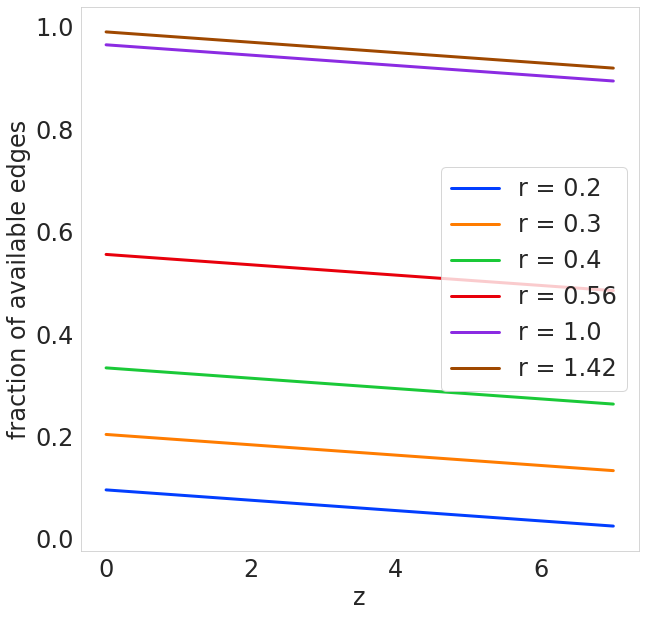

In [43]:
# [num_radii x num_trials x (max_num_edges / num_edges_step_size)]
available_edges_mean_over_trials = available_edges.mean(axis = 1)


df_available_edges_mean_over_trials = pd.DataFrame(available_edges_mean_over_trials)


complete_graph_E = N * (N-1)/2

fraction_available_nodes = (df_available_edges_mean_over_trials / complete_graph_E).T

fraction_available_nodes.columns = ['r = ' + str(radii[x]) for x in fraction_available_nodes.columns]


ax = fraction_available_nodes.iloc[:, 1:].plot(figsize=[10,10], linewidth=3);
ax.set_xlabel("z")
ax.set_ylabel("fraction of available edges");

fig = ax.get_figure()

fig.savefig('available_edges.pdf')

available_edges_mean_over_edges = available_edges_mean_over_trials.mean(axis=1)

# available_edges_mean_over_edges / complete_graph_E

# plot cascade size with confidence intervals

/home/galen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/galen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/galen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated

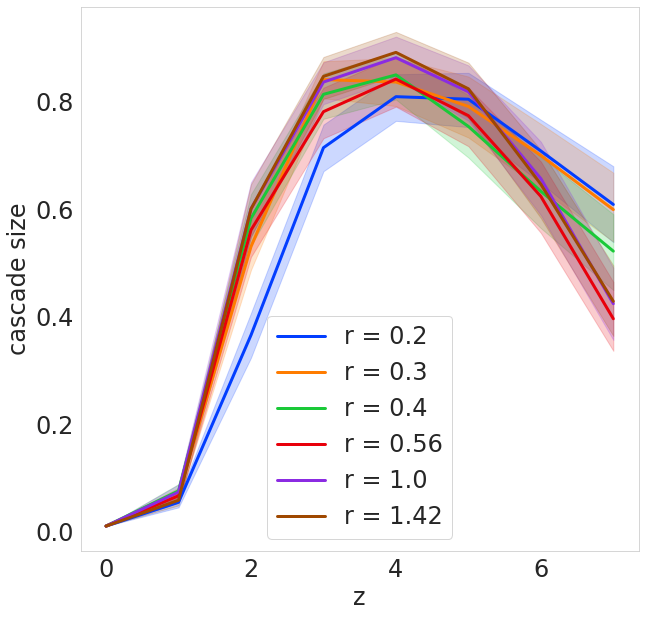

In [44]:
fig = plt.figure(figsize=[10,10]);
for i in range(1,len(radii)):
    # [num_trials x max_num_edges]
    df_cascade_sizes = pd.DataFrame(cascade_sizes[i,:,:]).T

    # z = 2 * E/N
    df_cascade_sizes['z'] = 2 * df_cascade_sizes.index * num_edges_step_size / N

    df2 = df_cascade_sizes.melt('z',var_name='cols',  value_name='vals')
    df2.columns = ['z', 'trial', 'cascade size']

   
    sns.lineplot(x="z", 
                 y='cascade size', 
                 ci=95, 
                 markers='.',  
                 label = 'r = ' + str(round(radii[i], 2)),
                 data=df2,
                 linewidth = 3);

fig.savefig('cascade_size_vs_z.pdf')

# cascade frequency with confidence intervals

/home/galen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/galen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/galen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated

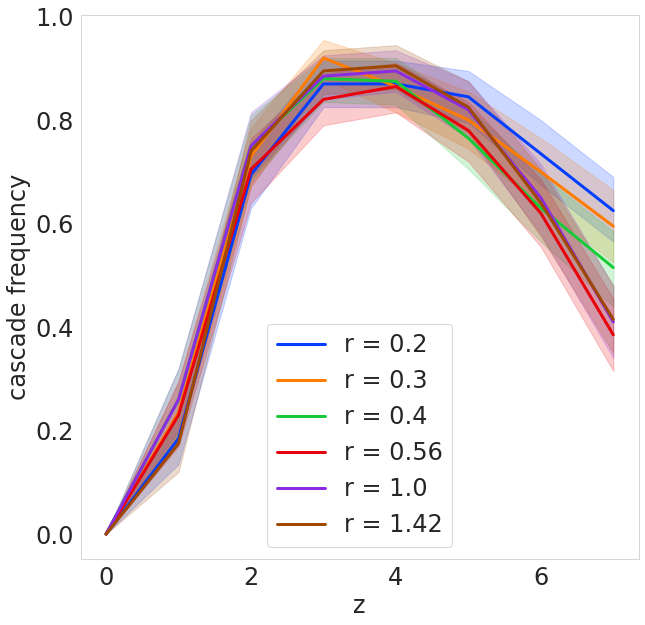

In [45]:
Phi = 0.1
df_global_cascades = df_cascade_sizes.copy()
df_global_cascades.drop('z', 1, inplace=True)
df_global_cascades = pd.DataFrame(df_global_cascades >= Phi)
#df_global_cascades

fig = plt.figure(figsize=[10,10])
for i in range(1,len(radii)):
    # [num_trials x max_num_edges]

    df_cascade_sizes = pd.DataFrame(cascade_sizes[i,:,:]).T
    df_global_cascades = df_cascade_sizes.copy()
    #df_global_cascades.drop('z', 1, inplace=True)
    df_global_cascades = pd.DataFrame(df_global_cascades >= Phi)

    # z = 2 * E/N
    df_global_cascades['z'] = 2 * df_global_cascades.index * num_edges_step_size / N

    df2 = df_global_cascades.melt('z',var_name='cols',  value_name='vals')
    df2.columns = ['z', 'trial', 'cascade frequency']
    
    sns.lineplot(x="z", 
                 y='cascade frequency', 
                 ci=95, 
                 markers='.',  
                 label = 'r = ' + str(round(radii[i], 2)),
                         #hue="cols",#, style="event",

                 data=df2,
                 linewidth = 3);

fig = fig.savefig('cascade_freq_vs_z.pdf')

# cascade 'efficiency' by fraction available edges with confidence intervals

/home/galen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/galen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/galen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated

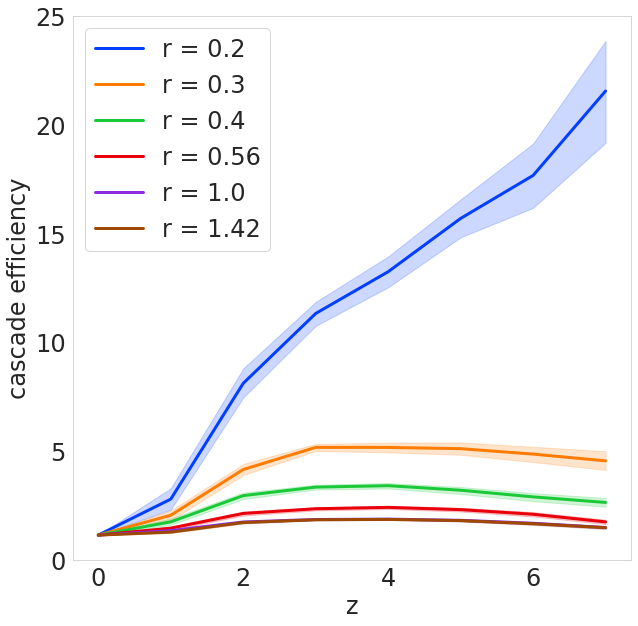

In [46]:
import matplotlib.ticker as ticker

fig, ax2 = plt.subplots(figsize=[10,10]) #plt.figure(figsize=[10,10])
#ax.set_yticks([0,5,10,15,20,25]);
ax2.yaxis.set_major_locator(ticker.LinearLocator(6))
ax2.set_yticklabels(['0', '5','10','15','20','25']);
#ax.yticks(np.arange(0, 30, 5));
#ax2.set_yticks(ax.get_yticks());
#ax2.set_yticklabels(ax.get_yticklabels());
for i in range(1, len(radii)):
    # [num_trials x max_num_edges]
    df_cascade_sizes = pd.DataFrame(cascade_sizes[i,:,:])
    df_cascade_sizes.shape


    df_global_cascades = df_cascade_sizes.copy()
    df_global_cascades = pd.DataFrame(df_global_cascades >= Phi)
    
    
    df_available_edges = pd.DataFrame(available_edges[i,:,:])
    df_available_edges.shape

    df_cascade_by_available_edges = df_global_cascades.div(df_available_edges).T
    
    
   

    df_cascade_by_available_edges['z'] = 2 * df_cascade_by_available_edges.index * num_edges_step_size / N
    
    df2 = df_cascade_by_available_edges.melt('z',var_name='cols',  value_name='vals')
    df2.columns = ['z', 'trial', 'cascade size / available edges']

   
    sns.lineplot(x="z",
                 y='cascade size / available edges', 
                 ci=95, 
                 markers='.',  
                 label = 'r = ' + str(round(radii[i], 2)),
                         #hue="cols",#, style="event",

                 data=df2,
                 linewidth = 3);
plt.ylabel('cascade efficiency');

fig = fig.savefig('cascade_efficiency_vs_z.pdf')

# loss is false negative rate

$ \beta $ is the false negative rate

$$
\beta = \frac{FN}{TP + FN} = \frac{FN}{N_{trials}} = 1-\text{sensitivity} = 1-\text{cascade frequency}  
$$

# loss with confidence intervals

/home/galen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/galen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/home/galen/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated

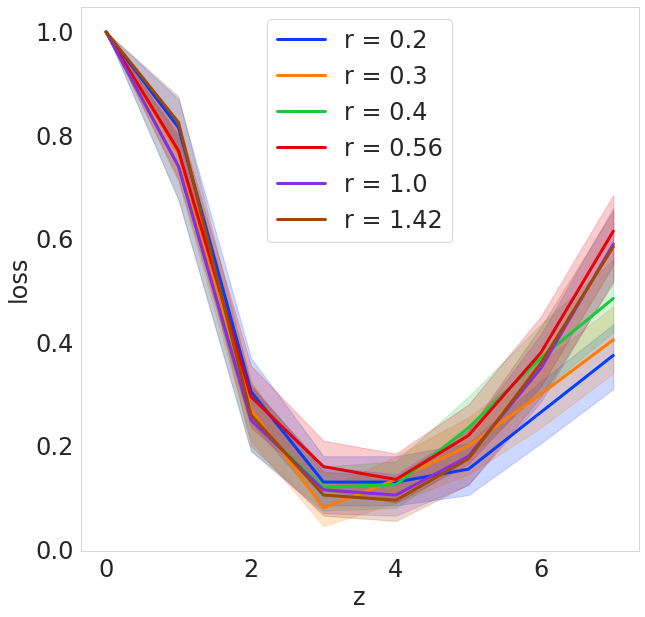

In [47]:
fig = plt.figure(figsize=[10,10])
for i in range(1,len(radii)):
    # [num_trials x max_num_edges]

    df_cascade_sizes = pd.DataFrame(cascade_sizes[i,:,:]).T
    df_global_cascades = df_cascade_sizes.copy()
    #df_global_cascades.drop('z', 1, inplace=True)
    df_global_cascades = pd.DataFrame(df_global_cascades < Phi)

    # z = 2 * E/N
    df_global_cascades['z'] = 2 * df_global_cascades.index * num_edges_step_size / N

    df2 = df_global_cascades.melt('z',var_name='cols',  value_name='vals')
    df2.columns = ['z', 'trial', 'loss']
    
    sns.lineplot(x="z", 
                 y='loss', 
                 ci=95, 
                 markers='.',  
                 label = 'r = ' + str(round(radii[i], 2)),
                 data=df2,
                 linewidth=3);

fig = fig.savefig('loss_vs_z.pdf')

# draw circle of influence

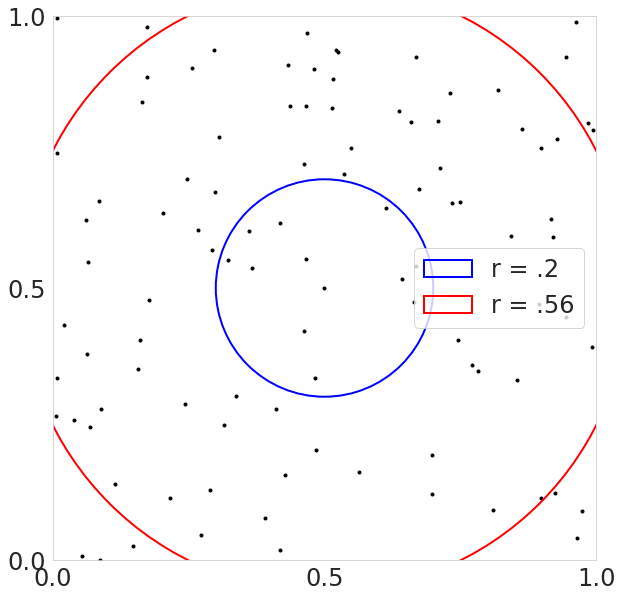

In [28]:
# now make a circle with no fill, which is good for hi-lighting key results
circle1 = plt.Circle((.5, .5), 0.2, color='b', fill=False, label = radii[1], linewidth = 2)
circle2 = plt.Circle((.5, .5), 0.3, color='y', fill=False, label = radii[2])
circle3 = plt.Circle((1, 1), 0.4, color='g', fill=False, label = radii[3])
circle4 = plt.Circle((.5,.5), .56, color='r', fill=False, label = radii[4], linewidth = 2)
circle5 = plt.Circle((1, 1), 1.0, color='purple', fill=False, label = radii[5])
circle6 = plt.Circle((1, 1), 1.414, color='brown', fill=False, label = radii[6])

fig = plt.figure(figsize=[10,10])
ax = plt.gca()


# change default range so that new circles will work
ax.set_xlim((0, 1))
ax.set_ylim((0, 1))

ax.add_artist(circle1)

ax.add_artist(circle4);

ax.set_aspect('equal', 'box');
ax.grid(False)
ax.set_xticks([0,.5,1])
ax.set_yticks([0,.5,1])
x = np.random.rand(99)
y = np.random.rand(99)
plt.scatter(x,y, marker='.', c = 'k');

# place one more node at center for example
plt.scatter(0.5, 0.5, marker='.', c = 'k');

custom_lines = [circle1, circle4]
ax.legend(custom_lines, ['r = .2', 'r = .56']);

fig = fig.savefig('circle.pdf')